In This Notebook, we generate random functions on the interval [0,1] using Gaussian Processes (GPs) with zero boundary values. We first create a 1D mesh with a specified number of grid points and then generate random functions at these grid points. We save the generated random functions to a file for later use.

These random functions can be used as initial values for the PDEs we will solve in the subsequent notebooks.

n_points = 100 or 50 are used in this notebook.


In [7]:
# In this cell, we define a function to get the cell center positions for a 1D mesh with the specified number of grid points.

n_points = 50

import fipy as fp
import numpy as np

def get_cell_centers(n_points = 50):
    """
    Get the cell center positions for a 1D mesh with the specified number of grid points.

    Parameters:
    - n_points: Number of grid points in the spatial domain.

    Returns:
    - cell_centers: The x-positions of the cell centers.
    """
    L = 1.0  # Length of the domain
    dx = L / n_points

    # Create a 1D mesh
    mesh = fp.Grid1D(nx=n_points, dx=dx)

    # Get the cell center positions
    cell_centers = mesh.cellCenters[0]  # These are the x-positions of the cell centers
    cell_centers = np.array(cell_centers)

    return cell_centers

# Example usage:
cell_centers = get_cell_centers(n_points = n_points)

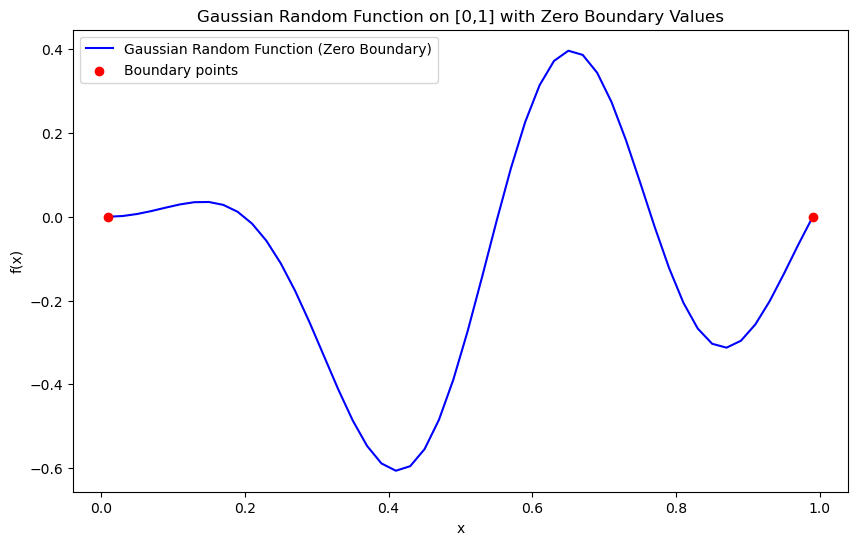

In [8]:
# In this cell, we define a function to generate a Gaussian random function with zero boundary values. Also, we plot the generated random function.

import numpy as np

def generate_random_function(points, length_scale=0.2, random_seed=2024):
    """
    Generate a Gaussian random function with zero boundary values.

    Parameters:
    - points: Array of points where the function is evaluated.
    - random_seed: Seed for the random number generator.

    Returns:
    - sample: A sample from the Gaussian random function.
    """
    def covariance_function(x1, x2, length_scale=length_scale):
        return np.exp(-0.5 * ((x1 - x2) ** 2) / length_scale ** 2)

    # Create the covariance matrix
    K_xx = np.array([[covariance_function(xi, xj) for xj in points] for xi in points])

    # Impose zero-boundary condition
    boundary_points = np.array([points[0], points[-1]])
    n_boundary_points = len(boundary_points)

    # Compute the covariance between boundary points and evaluation points
    K_xb = np.array([[covariance_function(xi, xb) for xb in boundary_points] for xi in points])
    K_bb = np.array([[covariance_function(xb1, xb2) for xb2 in boundary_points] for xb1 in boundary_points])

    # Conditional mean and covariance for GP given zero boundary values
    K_bb_inv = np.linalg.inv(K_bb)
    mu_conditional = K_xb @ K_bb_inv @ np.zeros(n_boundary_points)
    K_conditional = K_xx - K_xb @ K_bb_inv @ K_xb.T

    # Generate a sample from the conditional distribution
    np.random.seed(random_seed)  # For reproducibility
    random_function = np.random.multivariate_normal(mean=mu_conditional, cov=K_conditional)

    return random_function 

random_function = generate_random_function(cell_centers, random_seed=1954)


import matplotlib.pyplot as plt

def plot_random_function(cell_centers, random_function):
    """
    Plot the Gaussian random function with zero boundary values.

    Parameters:
    - cell_centers: Array of points where the function is evaluated.
    - random_function: The Gaussian random function values at the cell centers.
    """
    boundary_points = [cell_centers[0], cell_centers[-1]]
    
    plt.figure(figsize=(10, 6))
    plt.plot(cell_centers, random_function, label="Gaussian Random Function (Zero Boundary)", color="blue")
    plt.scatter(boundary_points, [0, 0], color="red", zorder=5, label="Boundary points")
    plt.title("Gaussian Random Function on [0,1] with Zero Boundary Values")
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.legend()
    plt.show()

# Example usage:
plot_random_function(cell_centers, random_function)

In [9]:
# In this cell, we generate multiple random functions. 

from tqdm.notebook import tqdm
num_samples = 500
random_functions = np.zeros((num_samples, len(cell_centers))) 

for i in tqdm(range(num_samples), desc="Generating random functions"):
    random_functions[i, :] = generate_random_function(cell_centers, random_seed=i+1954)

Generating random functions:   0%|          | 0/500 [00:00<?, ?it/s]

In [10]:
# In this cell, we save the generated random functions to a file.

import os
import numpy as np

# Define the directory where you want to save the file
save_directory = os.path.join(os.getcwd(), 'data')

# Create the directory if it does not exist
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

file_name = f'heat_initials_{len(cell_centers)}.npy'
# Define the file path
file_path = os.path.join(save_directory, file_name)

# Save the random functions to the file
np.save(file_path, random_functions)

print(f'File saved to: {file_path}')

File saved to: C:\Users\weiz828\DON\data\initial_values_50.npy


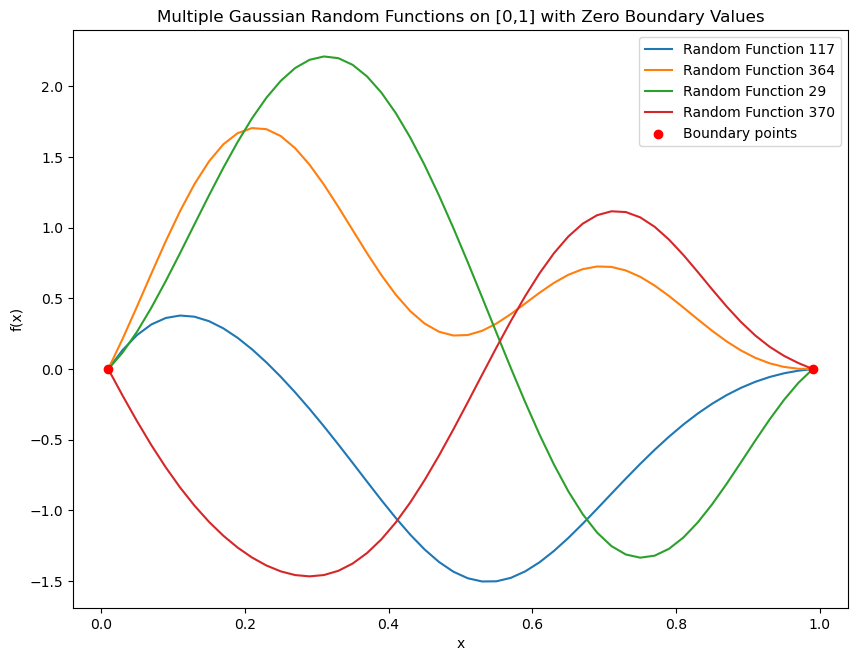

In [11]:
# In this cell, we load random functions from the file and plot multiple random functions.

import matplotlib.pyplot as plt

initial_values = np.load(file_path)

def plot_multiple_random_functions(cell_centers, random_functions, num_functions=5):
    """
    Plot multiple Gaussian random functions with zero boundary values.

    Parameters:
    - cell_centers: Array of points where the function is evaluated.
    - random_functions: Array of Gaussian random function values at the cell centers.
    - num_functions: Number of random functions to plot.
    """
    boundary_points = [cell_centers[0], cell_centers[-1]]
    plt.figure(figsize=(10, 7.5))

    random_numbers = np.random.randint(0, 500, size=num_functions)

    for i in random_numbers:
        plt.plot(cell_centers, random_functions[i], label=f"Random Function {i+1}")

    plt.scatter(boundary_points, [0, 0], color="red", zorder=5, label="Boundary points")
    plt.title("Multiple Gaussian Random Functions on [0,1] with Zero Boundary Values")
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.legend()
    plt.show()

# Example usage:
plot_multiple_random_functions(cell_centers, initial_values, num_functions=4)

In [14]:
'''
# In this cell, we check the shape of the loaded random functions.
## The first dimension corresponds to the number of random functions. Note that we have 500 initial conditions in total.
## The second dimension corresponds to the number of grid points. We have 100 or 50 grid points in total.
'''
initial_values.shape

(500, 50)